# ЗАНЯТИЕ 2.7. БУСТИНГ. ОБЗОР БИБЛИОТЕКИ XGBOOST

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

## Описание задачи

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [2]:
data = pd.read_csv('train.csv')

Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [4]:
data.shape

(22865, 133)

Разбиение на обучение и hold-out тест 70/30. Данных достаточно много, поэтому можно принебречь честной кросс-валидацией и оценивать модель на тесте

In [5]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

## Первичный анализ

Размер датасета

In [6]:
data.shape

(22865, 133)

Распределение значений таргета (event rate)

In [7]:
data.target.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [8]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     7168
v24        5
v30        7
v31        3
v47        9
v52       12
v56       93
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [9]:
from sklearn.metrics import auc, roc_curve

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
3. Создаем дамми-переменные для категорий

In [10]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

**Добавляем средние значения таргета внутри всех категориальных признаков по фолдам, через стекинг**

In [11]:
class MeanClassifier():
    def __init__(self, col):
        self._col = col
        
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()

    def predict_proba(self, X):
        new_feature = X[self._col].astype(str)\
            .map(self._means.to_dict())\
            .fillna(self._y_mean)
        return np.stack([1-new_feature, new_feature], axis=1)
    
    
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits


from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

for c in tqdm.tqdm(cat_nunique.index.tolist()):
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, y_train, d_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('mean_pred_{}'.format(c))

X_mean_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names, index=d_train.index)
X_mean_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names, index=d_test.index)

X_train = pd.concat([X_train, X_mean_train], axis=1)
X_test = pd.concat([X_test, X_mean_test], axis=1)

100%|██████████████████████████████████████████| 19/19 [00:12<00:00,  1.47it/s]


#### Считаем ROC AUC

In [12]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

## Обучение моделей

### Случайный лес

Предсказываем вероятность класса 1 и считаем ROC AUC

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=20, max_depth=5, min_samples_leaf=20, max_features=0.8, n_jobs=-1)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train:
ROC AUC: 0.7521
Test:
ROC AUC: 0.7363


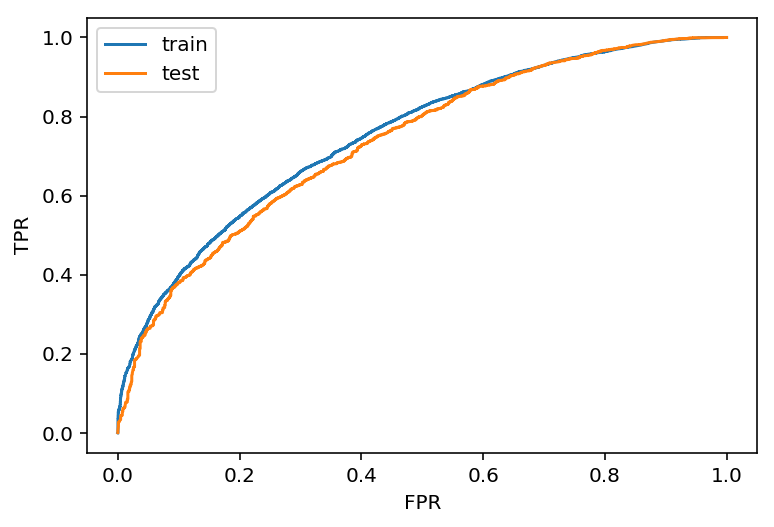

In [14]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_rf_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.legend();

### Бустинг в sklearn

In [15]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

Adaboost

Train:
ROC AUC: 0.7895
Test:
ROC AUC: 0.7358


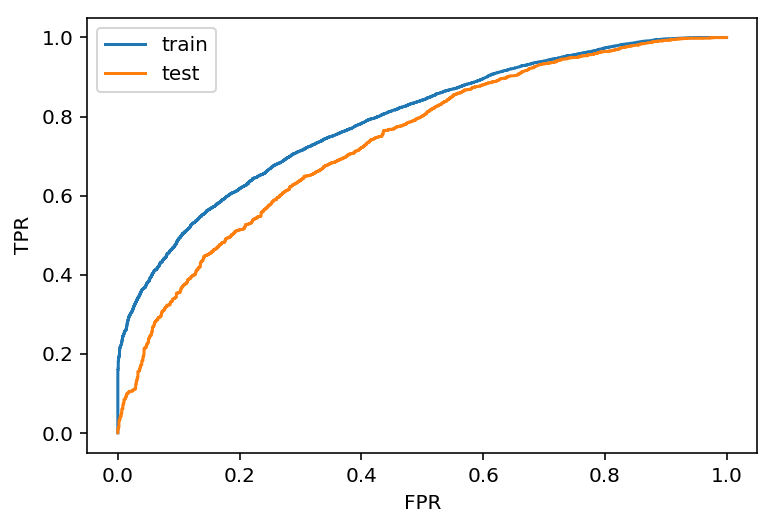

In [16]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, max_features=0.8),
                             n_estimators=20, learning_rate=0.1)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.legend();

GradientBoosting

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.0753           0.0253           16.00s
         2           1.0458           0.0176           14.96s
         3           1.0326           0.0142           13.89s
         4           1.0175           0.0113           12.64s
         5           1.0022           0.0107           11.80s
         6           0.9932           0.0089           10.93s
         7           0.9848           0.0076           10.16s
         8           0.9820           0.0056            9.34s
         9           0.9727           0.0047            8.52s
        10           0.9656           0.0044            7.70s
        11           0.9587           0.0039            6.95s
        12           0.9533           0.0024            6.22s
        13           0.9439           0.0013            5.45s
        14           0.9479           0.0021            4.66s
        15           0.9382           0.0010            3.86s
       

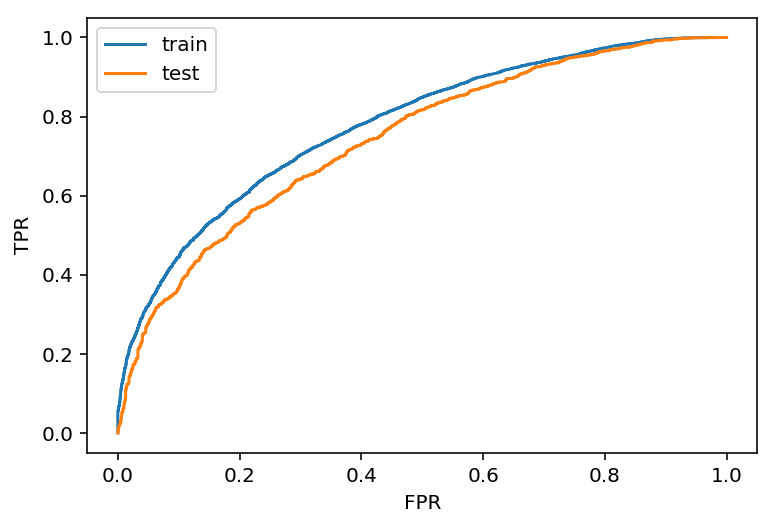

In [17]:
clf_gbm = GradientBoostingClassifier(max_depth=5, min_samples_leaf=20, n_estimators=20, learning_rate=0.1, 
                                     subsample=0.8, max_features=0.8, verbose=2)

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend();

### XGBOOST

In [18]:
import xgboost as xgb
# conda install -c anaconda py-xgboost

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. max_depth - максимальная глубина дерева (обычно 3-10, больше глубина -> больше риск переобучения)
    2. min_child_weight - минимальное число объектов в листе (обычно до 20, больше объектов -> меньше риск переобучения, но должен быть согласован с глубиной дерева)
    3. gamma - минимально необходимый прирост качества для разбиения листа (редко используется)

b. Параметры бустинга
    0. objective - оптимизируемый функционал (встроен для классификации и регрессии, можно написать свой дифференцируемый)
    1. n_estimators - кол-во базовых алгоритмов (чем меньше learning_rate, тем больше деревьев)
    2. learning_rate - шаг создания ансамбля (зависит от n_estimators, но обычно 0.01 - 0.1)
    2. colsample_bytree - доля признаков, случайно выбирающихся для построения дерева
    3. subsample - доля объектов, случайно выбирающихся для построения дерева
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)
    5. reg_alpha - вес L1 регуляризации (редко используется)
    6. reg_lambda - вес L2 регуляризации (редко используется)

Параметры по умолчанию

In [19]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': 4}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Train:
ROC AUC: 0.7767
Test:
ROC AUC: 0.7407


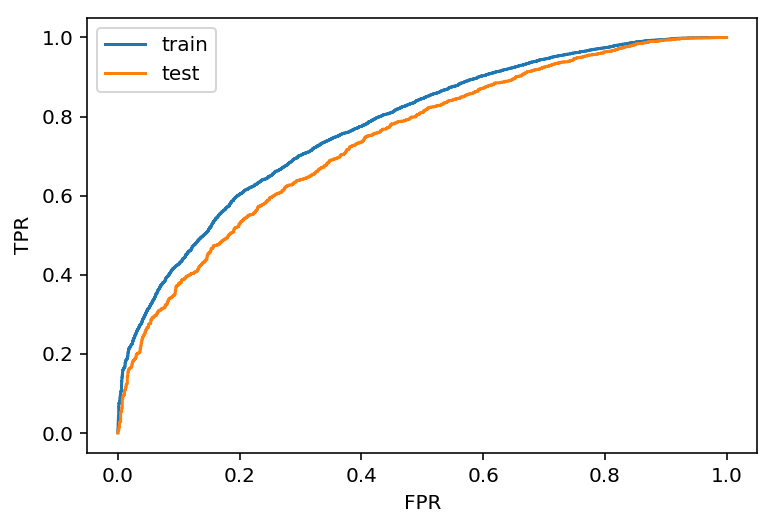

In [20]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.legend();

#### Онлайн оценка качества 

Во время обучения можно следить за качеством во время каждой итерации

Для этого используются параметры:
    1. eval_metric - метрика 'auc', 'rmse', 'logloss', ...
    2. eval_set - список выборок вида [(X, y), ...] на которых тестировать алгоритм

In [21]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.707057	validation_1-auc:0.710633
[1]	validation_0-auc:0.713917	validation_1-auc:0.712757
[2]	validation_0-auc:0.713913	validation_1-auc:0.713197
[3]	validation_0-auc:0.719527	validation_1-auc:0.721959
[4]	validation_0-auc:0.719556	validation_1-auc:0.722356
[5]	validation_0-auc:0.721113	validation_1-auc:0.722748
[6]	validation_0-auc:0.72181	validation_1-auc:0.724063
[7]	validation_0-auc:0.724771	validation_1-auc:0.727713
[8]	validation_0-auc:0.725834	validation_1-auc:0.727387
[9]	validation_0-auc:0.727845	validation_1-auc:0.73005
[10]	validation_0-auc:0.728308	validation_1-auc:0.7315
[11]	validation_0-auc:0.729433	validation_1-auc:0.731407
[12]	validation_0-auc:0.729845	validation_1-auc:0.731325
[13]	validation_0-auc:0.731194	validation_1-auc:0.732601
[14]	validation_0-auc:0.73211	validation_1-auc:0.733587
[15]	validation_0-auc:0.732692	validation_1-auc:0.733318
[16]	validation_0-auc:0.733286	validation_1-auc:0.734206
[17]	validation_0-auc:0.733632	validation_1-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Самостоятельное задание

Сравнить алгоритмы AdaBoost, GradientBoostingClassifier и Xgboost с похожим набором параметров

In [22]:
### TODO













### TODO

Возмем параметры, с которых лучше всего начать

In [23]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.722945	validation_1-auc:0.71799
[1]	validation_0-auc:0.736733	validation_1-auc:0.72805
[2]	validation_0-auc:0.745734	validation_1-auc:0.732616
[3]	validation_0-auc:0.751147	validation_1-auc:0.737171
[4]	validation_0-auc:0.753767	validation_1-auc:0.73485
[5]	validation_0-auc:0.75528	validation_1-auc:0.735353
[6]	validation_0-auc:0.755945	validation_1-auc:0.735828
[7]	validation_0-auc:0.75734	validation_1-auc:0.735229
[8]	validation_0-auc:0.759171	validation_1-auc:0.734859
[9]	validation_0-auc:0.760638	validation_1-auc:0.735403
[10]	validation_0-auc:0.76229	validation_1-auc:0.734742
[11]	validation_0-auc:0.764463	validation_1-auc:0.73692
[12]	validation_0-auc:0.765921	validation_1-auc:0.738113
[13]	validation_0-auc:0.767232	validation_1-auc:0.738795
[14]	validation_0-auc:0.768231	validation_1-auc:0.739189
[15]	validation_0-auc:0.770524	validation_1-auc:0.740948
[16]	validation_0-auc:0.771756	validation_1-auc:0.741106
[17]	validation_0-auc:0.774468	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

Достанем из объекта clf_xgb списки результатов метрик по итерациям, построим графики

Text(0.5,0,'iteration number')

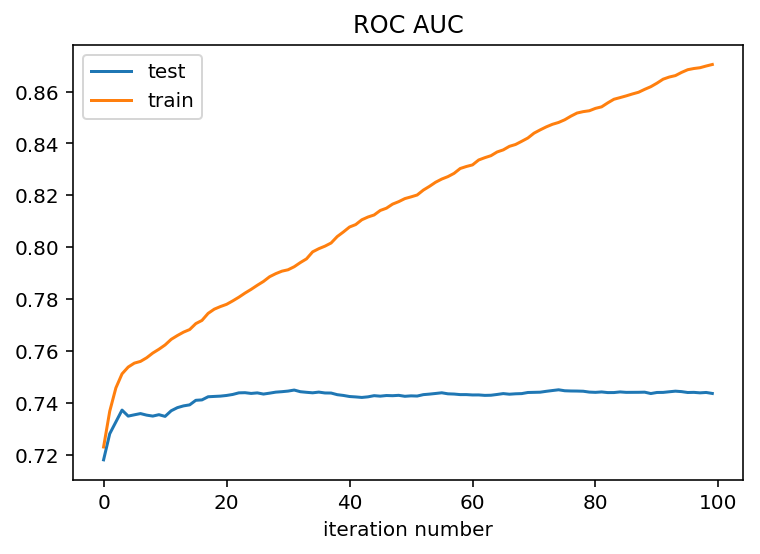

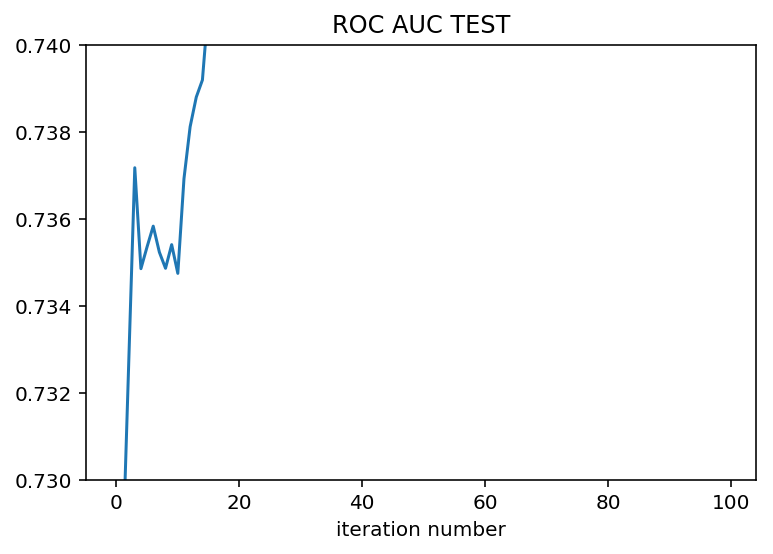

In [24]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.73, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')

Нужно побороть переобучение, уменьшим learning_rate. Также уменьшим кол-во деревьев для ускорения обучения

In [25]:
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.722945	validation_1-auc:0.71799
[1]	validation_0-auc:0.736247	validation_1-auc:0.728467
[2]	validation_0-auc:0.745095	validation_1-auc:0.731458
[3]	validation_0-auc:0.750499	validation_1-auc:0.735368
[4]	validation_0-auc:0.751147	validation_1-auc:0.735539
[5]	validation_0-auc:0.751404	validation_1-auc:0.734413
[6]	validation_0-auc:0.751862	validation_1-auc:0.735741
[7]	validation_0-auc:0.752926	validation_1-auc:0.735004
[8]	validation_0-auc:0.753503	validation_1-auc:0.735799
[9]	validation_0-auc:0.754698	validation_1-auc:0.73702
[10]	validation_0-auc:0.755388	validation_1-auc:0.736199
[11]	validation_0-auc:0.756022	validation_1-auc:0.735374
[12]	validation_0-auc:0.756684	validation_1-auc:0.73562
[13]	validation_0-auc:0.757175	validation_1-auc:0.736693
[14]	validation_0-auc:0.757316	validation_1-auc:0.736965
[15]	validation_0-auc:0.759191	validation_1-auc:0.738105
[16]	validation_0-auc:0.759726	validation_1-auc:0.738583
[17]	validation_0-auc:0.76103	validation_1-a

### Перебор параметров по сетке

Опишем функцию, похожую на GridSearchCV, только для одной отложенной выборки X_test. Она перебирает параметки по заданной сетке и возврашает лучшие по ROC AUC

In [26]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

**Процесс подбора параметров**:

1. Зафиксируем learning_rate и n_estimators, чтобы модель не переобучалась во время итераций
2. Настраиваем параметры деревьев: max_depth и min_child_weight
3. Настраиваем gamma (опционально)
4. Настраиваем subsample и colsample_bytree
5. Настраиваем регуляризацию reg_lambda и reg_alpha
6. Уменьшаем learning_rate, увеличиваем кол-во деревьев и обучаем заново на лучших параметрах

#### Подбираем max_depth и min_child_weight

In [28]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_depth=3, min_child_weight=10 ................................
[CV]  max_depth=3, min_child_weight=10, score=0.7366111218093406, total=   6.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] max_depth=3, min_child_weight=20 ................................
[CV]  max_depth=3, min_child_weight=20, score=0.7366255907264239, total=   5.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV] max_depth=3, min_child_weight=100 ...............................
[CV]  max_depth=3, min_child_weight=100, score=0.7358662356507804, total=   5.6s
[CV] max_depth=5, min_child_weight=10 ................................
[CV]  max_depth=5, min_child_weight=10, score=0.7436548537166177, total=   9.4s
[CV] max_depth=5, min_child_weight=20 ................................
[CV]  max_depth=5, min_child_weight=20, score=0.7421506124824138, total=   9.2s
[CV] max_depth=5, min_child_weight=100 ...............................
[CV]  max_depth=5, min_child_weight=100, score=0.7397850760749353, total=   8.7s
[CV] max_depth=10, min_child_weight=10 ...............................
[CV]  max_depth=10, min_child_weight=10, score=0.7412607740818025, total=  17.8s
[CV] max_depth=10, min_child_weight=20 ...............................
[CV]  max_depth=10, min_child_weight=20, score=0.7400962893278321, total=  17.4s
[CV] max_depth=10, min_child_weight=100 ..............................
[CV]  max_depth=10,

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min finished


Best test ROC AUC:  0.7436548537166177
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8}


#### Подбираем gamma

In [29]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.7436548537166177, total=  10.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV] gamma=0.125 .....................................................
[CV] ............ gamma=0.125, score=0.7436367018024589, total=   9.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.6s remaining:    0.0s


[CV] gamma=0.25 ......................................................
[CV] ............. gamma=0.25, score=0.7436527491468601, total=   9.4s
[CV] gamma=0.375 .....................................................
[CV] ............ gamma=0.375, score=0.7436527491468601, total=   9.3s
[CV] gamma=0.5 .......................................................
[CV] .............. gamma=0.5, score=0.7435460737672746, total=  10.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.1s finished


Best test ROC AUC:  0.7436548537166177
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8}


#### Подбираем subsample и colsample_bytree

In [30]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 3),
    'colsample_bytree': np.linspace(0.5, 1, 3)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] colsample_bytree=0.5, subsample=0.5 .............................
[CV]  colsample_bytree=0.5, subsample=0.5, score=0.7418245357056042, total=   8.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=0.7438605754104175, total=   6.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s


[CV] colsample_bytree=0.5, subsample=1.0 .............................
[CV]  colsample_bytree=0.5, subsample=1.0, score=0.7430183529005706, total=   6.2s
[CV] colsample_bytree=0.75, subsample=0.5 ............................
[CV]  colsample_bytree=0.75, subsample=0.5, score=0.7404460425144137, total=   8.1s
[CV] colsample_bytree=0.75, subsample=0.75 ...........................
[CV]  colsample_bytree=0.75, subsample=0.75, score=0.7425170706914459, total=   9.3s
[CV] colsample_bytree=0.75, subsample=1.0 ............................
[CV]  colsample_bytree=0.75, subsample=1.0, score=0.7427075342545035, total=   9.6s
[CV] colsample_bytree=1.0, subsample=0.5 .............................
[CV]  colsample_bytree=1.0, subsample=0.5, score=0.7377854717340497, total=  10.5s
[CV] colsample_bytree=1.0, subsample=0.75 ............................
[CV]  colsample_bytree=1.0, subsample=0.75, score=0.7391598873213352, total=  12.2s
[CV] colsample_bytree=1.0, subsample=1.0 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min finished


Best test ROC AUC:  0.7438605754104175
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.75}


#### Подбираем регуляризацию: reg_lambda и reg_alpha

In [31]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV]  reg_alpha=0, reg_lambda=0, score=0.7434533411623327, total=   7.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] reg_alpha=0, reg_lambda=0.001 ...................................
[CV]  reg_alpha=0, reg_lambda=0.001, score=0.7434514996637949, total=   6.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV]  reg_alpha=0, reg_lambda=0.1, score=0.7436585367136932, total=   6.1s
[CV] reg_alpha=0, reg_lambda=1 .......................................
[CV]  reg_alpha=0, reg_lambda=1, score=0.7438605754104175, total=   6.1s
[CV] reg_alpha=0.001, reg_lambda=0 ...................................
[CV]  reg_alpha=0.001, reg_lambda=0, score=0.7434517627350147, total=   6.5s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV]  reg_alpha=0.001, reg_lambda=0.001, score=0.7434513681281851, total=   8.0s
[CV] reg_alpha=0.001, reg_lambda=0.1 .................................
[CV]  reg_alpha=0.001, reg_lambda=0.1, score=0.7436584051780835, total=   8.1s
[CV] reg_alpha=0.001, reg_lambda=1 ...................................
[CV]  reg_alpha=0.001, reg_lambda=1, score=0.7438608384816371, total=   6.6s
[CV] reg_alpha=0.1, reg_lambda=0 .....................................
[CV]  reg_alpha=0.1, reg_lambda=0, score=

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.9min finished


Best test ROC AUC:  0.7440644556056794
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.75}


#### Уменьшим learning_rate

In [32]:
best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.724422	validation_1-auc:0.718837
[1]	validation_0-auc:0.73456	validation_1-auc:0.720338
[2]	validation_0-auc:0.733187	validation_1-auc:0.719683
[3]	validation_0-auc:0.745425	validation_1-auc:0.730493
[4]	validation_0-auc:0.749855	validation_1-auc:0.735448
[5]	validation_0-auc:0.750061	validation_1-auc:0.73625
[6]	validation_0-auc:0.751189	validation_1-auc:0.738318
[7]	validation_0-auc:0.751831	validation_1-auc:0.739025
[8]	validation_0-auc:0.752557	validation_1-auc:0.738981
[9]	validation_0-auc:0.753708	validation_1-auc:0.739313
[10]	validation_0-auc:0.753385	validation_1-auc:0.73893
[11]	validation_0-auc:0.753365	validation_1-auc:0.738403
[12]	validation_0-auc:0.753665	validation_1-auc:0.739159
[13]	validation_0-auc:0.754557	validation_1-auc:0.73993
[14]	validation_0-auc:0.754386	validation_1-auc:0.74048
[15]	validation_0-auc:0.75485	validation_1-auc:0.740406
[16]	validation_0-auc:0.755155	validation_1-auc:0.740393
[17]	validation_0-auc:0.755072	validation_1-auc

[144]	validation_0-auc:0.770978	validation_1-auc:0.744685
[145]	validation_0-auc:0.771122	validation_1-auc:0.744672
[146]	validation_0-auc:0.771165	validation_1-auc:0.744709
[147]	validation_0-auc:0.771293	validation_1-auc:0.744748
[148]	validation_0-auc:0.771376	validation_1-auc:0.744701
[149]	validation_0-auc:0.771457	validation_1-auc:0.744661
[150]	validation_0-auc:0.771632	validation_1-auc:0.744753
[151]	validation_0-auc:0.7717	validation_1-auc:0.744778
[152]	validation_0-auc:0.771828	validation_1-auc:0.744792
[153]	validation_0-auc:0.771939	validation_1-auc:0.74482
[154]	validation_0-auc:0.772005	validation_1-auc:0.744809
[155]	validation_0-auc:0.7721	validation_1-auc:0.744916
[156]	validation_0-auc:0.772095	validation_1-auc:0.744946
[157]	validation_0-auc:0.772165	validation_1-auc:0.744929
[158]	validation_0-auc:0.772262	validation_1-auc:0.74497
[159]	validation_0-auc:0.772384	validation_1-auc:0.744948
[160]	validation_0-auc:0.77248	validation_1-auc:0.744953
[161]	validation_0-au

[286]	validation_0-auc:0.785363	validation_1-auc:0.745785
[287]	validation_0-auc:0.78552	validation_1-auc:0.745825
[288]	validation_0-auc:0.785646	validation_1-auc:0.745881
[289]	validation_0-auc:0.785762	validation_1-auc:0.745949
[290]	validation_0-auc:0.785926	validation_1-auc:0.745946
[291]	validation_0-auc:0.786	validation_1-auc:0.745911
[292]	validation_0-auc:0.786112	validation_1-auc:0.745947
[293]	validation_0-auc:0.786183	validation_1-auc:0.745908
[294]	validation_0-auc:0.786264	validation_1-auc:0.745923
[295]	validation_0-auc:0.786328	validation_1-auc:0.745951
[296]	validation_0-auc:0.786468	validation_1-auc:0.745905
[297]	validation_0-auc:0.786613	validation_1-auc:0.745893
[298]	validation_0-auc:0.786713	validation_1-auc:0.745918
[299]	validation_0-auc:0.786869	validation_1-auc:0.74587
[300]	validation_0-auc:0.786957	validation_1-auc:0.745873
[301]	validation_0-auc:0.787022	validation_1-auc:0.745842
[302]	validation_0-auc:0.787144	validation_1-auc:0.745858
[303]	validation_0-

[428]	validation_0-auc:0.799263	validation_1-auc:0.7468
[429]	validation_0-auc:0.799411	validation_1-auc:0.746812
[430]	validation_0-auc:0.799585	validation_1-auc:0.746855
[431]	validation_0-auc:0.799669	validation_1-auc:0.746823
[432]	validation_0-auc:0.799729	validation_1-auc:0.746791
[433]	validation_0-auc:0.799771	validation_1-auc:0.746833
[434]	validation_0-auc:0.799898	validation_1-auc:0.746849
[435]	validation_0-auc:0.799967	validation_1-auc:0.746867
[436]	validation_0-auc:0.799991	validation_1-auc:0.746848
[437]	validation_0-auc:0.800032	validation_1-auc:0.74683
[438]	validation_0-auc:0.800116	validation_1-auc:0.746859
[439]	validation_0-auc:0.800303	validation_1-auc:0.746871
[440]	validation_0-auc:0.800426	validation_1-auc:0.746891
[441]	validation_0-auc:0.800526	validation_1-auc:0.746933
[442]	validation_0-auc:0.800604	validation_1-auc:0.746899
[443]	validation_0-auc:0.800655	validation_1-auc:0.746882
[444]	validation_0-auc:0.800718	validation_1-auc:0.746897
[445]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=10, missing=None,
       n_estimators=500, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.75)

Визуализируем метрику в зависимости от итерации

Text(0.5,0,'iteration number')

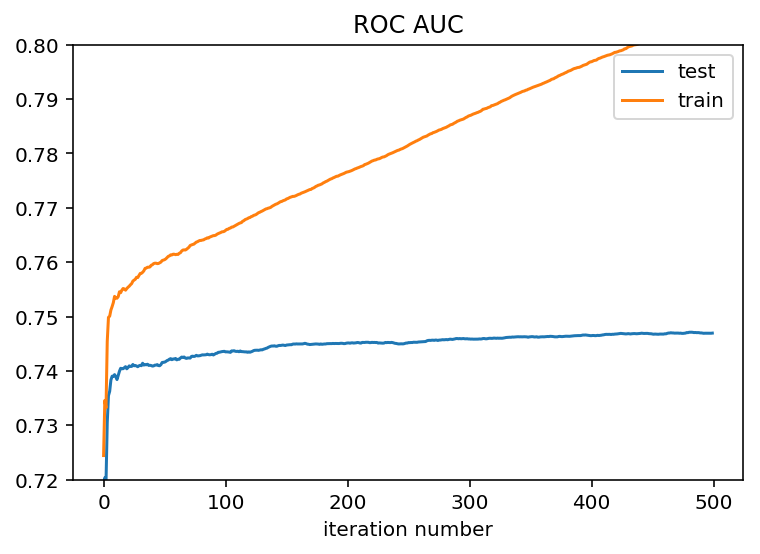

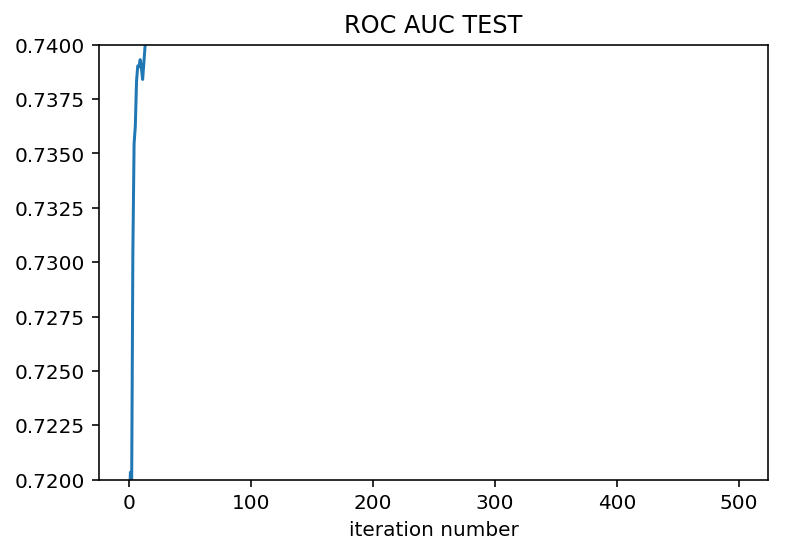

In [33]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.8), title='ROC AUC')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.72, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')

### HyperOpt

http://hyperopt.github.io/hyperopt/

Инструмент для автоматической "умной" оптимизации большого числа гиперпараметров. Использует алгоритм Tree of Parzen Estimators

In [36]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 50,
         'learning_rate': 0.03
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

TypeError: 'generator' object is not subscriptable

In [35]:
best

NameError: name 'best' is not defined

In [ ]:
trials.best_trial

### Важность признаков

#### Встроенные методы

Нужно вытащить из sklearn обертки оригинальный объект класса xgboost.core.Booster

Есть 3 типа важности в get_score():

    weight - суммарное кол-во раз, когда признак использовался для разбиения вершины
    gain - средний прирост качества, когда признак использовался для разбиения вершины
    cover - среднее кол-во объектов, которые попадали в разбиение по признаку, когда он использовался для разбиения вершины

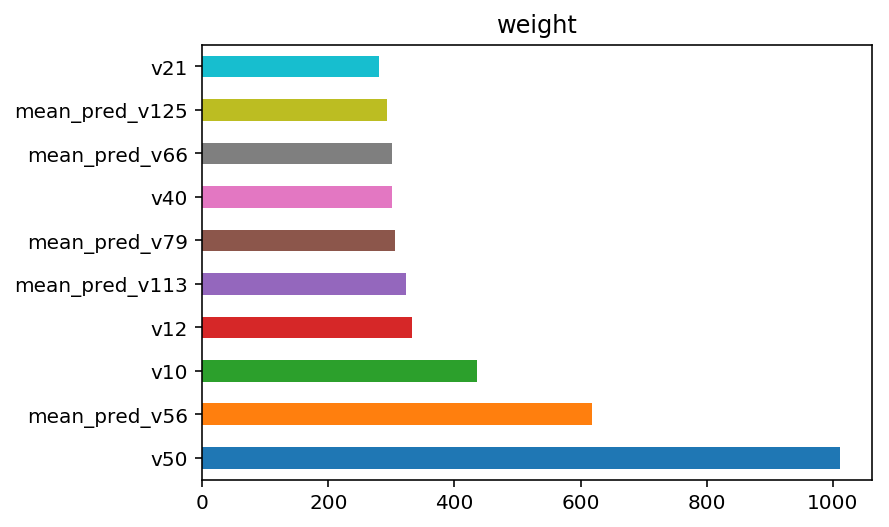

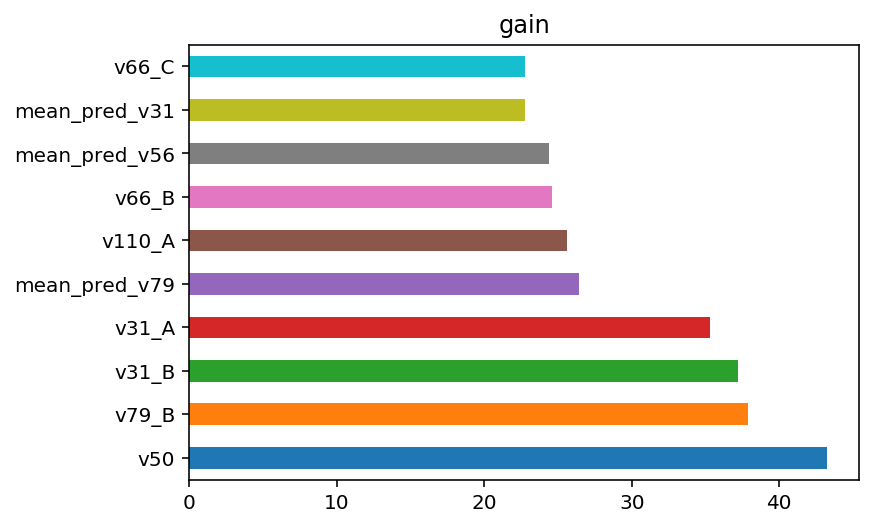

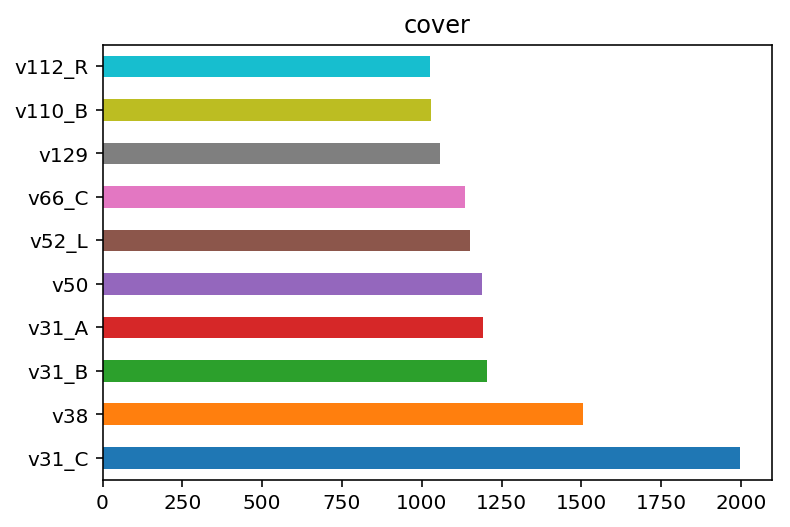

In [37]:
bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

#### XGBFI

Позволяет оценивать важности взаимодействия признаков

https://github.com/limexp/xgbfir

In [39]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [41]:
pd.read_excel('xgbfi_report.xlsx', sheetname=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,mean_pred_v56|v50,18055.526026,96,29.854023,0.310979,188.078396,8169.408435,1,1,1,20,13,2,6.333333,45.656250,2.208333
1,v50|v50,14728.428359,49,22.021742,0.449423,300.580171,8741.897698,2,4,2,10,2,1,3.500000,46.755102,1.714286
2,mean_pred_v113|v50,14063.401640,62,15.015182,0.242180,226.829059,4483.029654,3,3,3,34,6,3,8.666667,44.467742,2.000000
3,v50|v66_B,8745.435240,86,12.279489,0.142785,101.691107,1362.342831,4,2,4,78,31,8,21.166667,47.267442,2.848837
4,mean_pred_v79|v50,4942.187370,32,6.879308,0.214978,154.443355,1655.534600,5,8,8,44,17,6,14.666667,24.937500,2.437500
5,mean_pred_v66|v50,4241.832000,49,6.785379,0.138477,86.568000,719.555946,6,5,9,80,46,14,26.666667,58.918367,2.918367
6,mean_pred_v31|v50,4181.793995,28,7.524578,0.268735,149.349786,1760.569443,7,10,6,28,19,5,12.500000,37.250000,2.107143
7,mean_pred_v79|v66_C,3587.156890,17,8.730438,0.513555,211.009229,2194.249624,8,18,5,8,9,4,8.666667,32.000000,1.823529
8,mean_pred_v56|mean_pred_v79,2765.560300,13,6.353961,0.488766,212.735408,1648.582876,9,25,11,9,8,7,11.500000,41.692308,1.615385
9,mean_pred_v113|mean_pred_v56,2569.924300,19,6.882416,0.362232,135.259174,1294.932873,10,15,7,14,20,9,12.500000,39.526316,2.368421


# Домашняя работа

#### Простая
1. Решаем ту же задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Используем **objective = "reg:linear"** в xgboost
5. Провести настройку гиперпараметров, используя либо hyperopt либо ручную настройку, как вам больше нравится
6. Использовать отложенную выборку (как на занятии), чтобы следить за процессом обучения xgboost'а, но, как и в предыдущем домашнем задании, финальную оценку качества давать используя 10-fold кросс-валидацию.
4. Проанализировать, насколько согласованы оценка на отложенной выборке и на кросс-валидации (одновременно уменьшаются/увеличиваются при изменении гиперпараметров или ведут себя по-разному)
5. Проанализировать признаки, используя XGBFI, сделать выводы об интересных взаимодействиях
7. В качестве решения:
    Jupyter notebook с кодом и комментариями